In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
# file paths
csv1_file_path = "DataFiles/FRNSW_data_export_daily_20250513.csv" 
csv2_file_path = "DataFiles/combined_attributes.csv"

In [4]:
# expand the '~' to the full path
csv1_file_path = os.path.expanduser(csv1_file_path)
csv2_file_path = os.path.expanduser(csv2_file_path)

In [5]:
# reading in the files
csv1_data = pd.read_csv(csv1_file_path, encoding='latin1') 
csv2_data = pd.read_csv(csv2_file_path, encoding='utf-8-sig')
csv2_data = csv2_data.iloc[:, 1:]  # drops the first column

In [6]:
# Convert REPORT_DATE to datetime for consistent merging
csv1_data['REPORT_DATE'] = pd.to_datetime(csv1_data['REPORT_DATE'])
csv2_data['Date'] = pd.to_datetime(csv2_data['Date'])

In [7]:
# Rename the 'Date' column to match
csv2_data.rename(columns={'Date': 'REPORT_DATE'}, inplace=True)

In [8]:
# Merging the dataframes on the REPORT_DATE column
merged_data = pd.merge(csv1_data, csv2_data, on="REPORT_DATE", how="inner")

In [9]:
# Preview the merged data
print(merged_data.head())

  REPORT_DATE  FIRES_INCDS  WIRES_DOWN_INCDS  MEDICAL_INCDS  \
0  2024-11-26           87                 5             51   
1  2024-11-26           87                 5             51   
2  2024-11-25           91                 6             34   
3  2024-11-25           91                 6             34   
4  2024-11-24           87                 4             29   

   BUSH_AND_GRASS_FIRE_INCDS  HAZARDOUS_MATERIAL_INCDS  RESCUE_INCDS  \
0                         21                        34            39   
1                         21                        34            39   
2                         25                        34            26   
3                         25                        34            26   
4                         30                        21            37   

   STORM_RELATED_INCDS  AUTOMATIC_FIRE_ALARM_INCDS  OTHER_INCDS  ...  \
0                    5                         197           71  ...   
1                    5                      

In [10]:
# Define constants for column names used in analysis of FIRES_INCDS
FIRE_INCIDENTS_COLUMN = 'FIRES_INCDS'
WIND_SPEED_COLUMN = '9am wind speed (km/h)'
TEMPERATURE_COLUMN = '9am Temperature (°C)'
HUMIDITY_COLUMN = '9am relative humidity (%)'
CLOUD_AMOUNT_COLUMN = '9am cloud amount (oktas)'
PRESSURE_COLUMN = '9am MSL pressure (hPa)'

In [11]:
# New Emergency Callout Types for additional analyses
STORM_INCIDENTS_COLUMN = 'STORM_RELATED_INCDS'
WIRES_DOWN_COLUMN       = 'WIRES_DOWN_INCDS'

In [12]:
# Replace 'Calm' with 0 in wind speed columns (handle case-insensitive matching)
merged_data[WIND_SPEED_COLUMN] = pd.to_numeric(
    merged_data[WIND_SPEED_COLUMN].replace(r'(?i)^\s*calm\s*$', 0, regex=True),
    errors='coerce'
)

In [13]:
# Ensure required columns (for FIRES_INCDS analysis) are numeric
columns_to_check = [
    FIRE_INCIDENTS_COLUMN,
    TEMPERATURE_COLUMN, 
    HUMIDITY_COLUMN, 
    CLOUD_AMOUNT_COLUMN, 
    WIND_SPEED_COLUMN, 
    PRESSURE_COLUMN
]
merged_data[columns_to_check] = merged_data[columns_to_check].apply(pd.to_numeric, errors='coerce')

================================================
ANALYSIS 1: FIRES_INCDS vs Weather
================================================

In [14]:
# Drop rows with missing values in the key columns
cleaned_data = merged_data.dropna(subset=columns_to_check)

In [15]:
# Calculate correlation matrix for FIRES_INCDS and weather-related columns
correlation_matrix = cleaned_data[columns_to_check].corr()
print("\nCorrelation Matrix for FIRES_INCDS and Weather:")
print(correlation_matrix)


Correlation Matrix for FIRES_INCDS and Weather:
                           FIRES_INCDS  9am Temperature (°C)  \
FIRES_INCDS                   1.000000              0.189995   
9am Temperature (°C)          0.189995              1.000000   
9am relative humidity (%)    -0.424009             -0.294080   
9am cloud amount (oktas)     -0.333604              0.010351   
9am wind speed (km/h)         0.126692             -0.247337   
9am MSL pressure (hPa)       -0.130876             -0.333062   

                           9am relative humidity (%)  \
FIRES_INCDS                                -0.424009   
9am Temperature (°C)                       -0.294080   
9am relative humidity (%)                   1.000000   
9am cloud amount (oktas)                    0.364859   
9am wind speed (km/h)                      -0.263188   
9am MSL pressure (hPa)                      0.401989   

                           9am cloud amount (oktas)  9am wind speed (km/h)  \
FIRES_INCDS                    

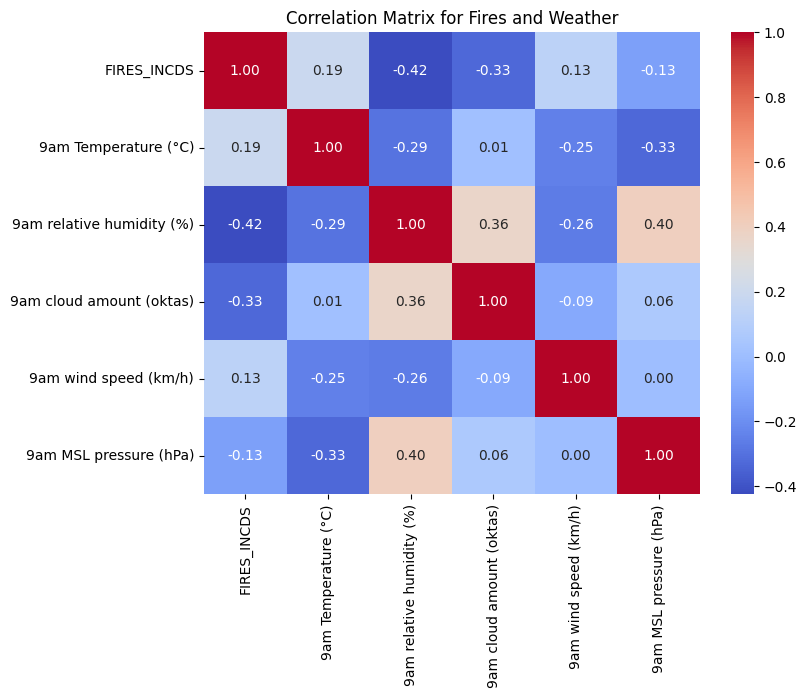

In [16]:
# Plot correlation heatmap for FIRES_INCDS
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Fires and Weather')
plt.show()

In [17]:
# Summary statistics and distribution plots
print("\nSummary Statistics:")
print(merged_data.describe())


Summary Statistics:
                         REPORT_DATE  FIRES_INCDS  WIRES_DOWN_INCDS  \
count                            478   478.000000        478.000000   
mean   2024-07-29 12:33:08.284518912    80.560669          6.447699   
min              2024-04-01 00:00:00    56.000000          0.000000   
25%              2024-05-30 06:00:00    71.000000          3.000000   
50%              2024-07-30 00:00:00    80.000000          4.000000   
75%              2024-09-27 18:00:00    88.000000          6.000000   
max              2024-11-26 00:00:00   124.000000        101.000000   
std                              NaN    12.761786         11.103307   

       MEDICAL_INCDS  BUSH_AND_GRASS_FIRE_INCDS  HAZARDOUS_MATERIAL_INCDS  \
count     478.000000                 478.000000                478.000000   
mean       34.635983                  10.702929                 26.707113   
min        15.000000                   0.000000                 11.000000   
25%        28.000000           

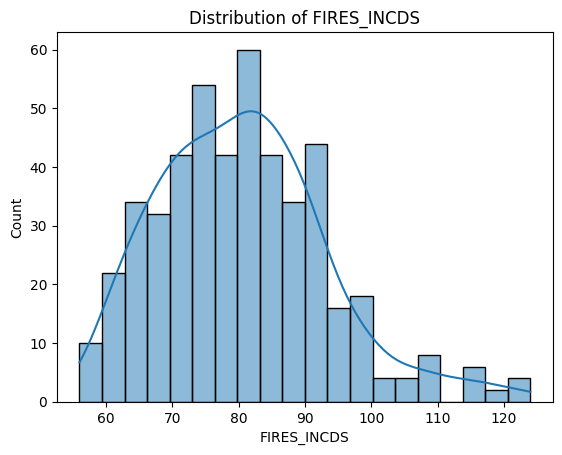

In [18]:
sns.histplot(merged_data[FIRE_INCIDENTS_COLUMN], bins=20, kde=True)
plt.title("Distribution of FIRES_INCDS")
plt.show()

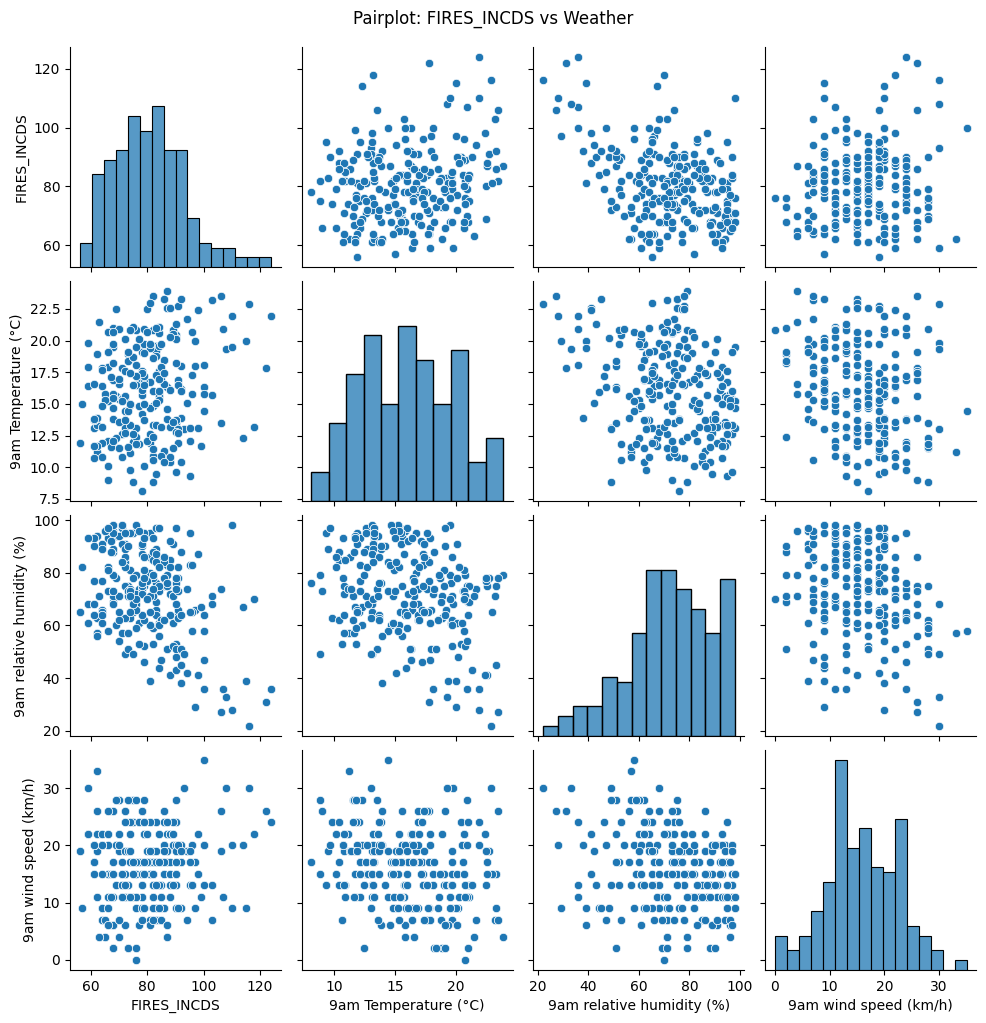

In [19]:
sns.pairplot(merged_data[[FIRE_INCIDENTS_COLUMN, TEMPERATURE_COLUMN, HUMIDITY_COLUMN, WIND_SPEED_COLUMN]])
plt.suptitle("Pairplot: FIRES_INCDS vs Weather", y=1.02)
plt.show()

In [20]:
# Regression analysis for FIRES_INCDS using three predictors
predictors = [HUMIDITY_COLUMN, WIND_SPEED_COLUMN, TEMPERATURE_COLUMN]
target = FIRE_INCIDENTS_COLUMN

In [21]:
regression_data = merged_data.dropna(subset=predictors + [target])
X = regression_data[predictors]
y = regression_data[target]

In [22]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [23]:
print("\nRegression Analysis for FIRES_INCDS:")
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 score:", model.score(X, y))


Regression Analysis for FIRES_INCDS:
Coefficients: [-0.29499243  0.08960723  0.30316481]
Intercept: 95.47440015498167
R^2 score: 0.18625239531698023


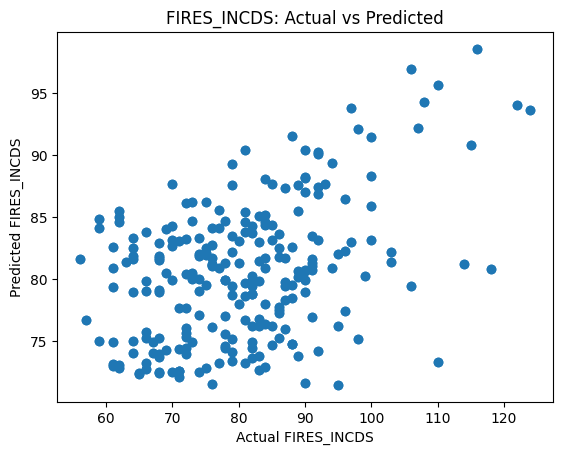

In [24]:
# Plot actual vs predicted for FIRES_INCDS
y_pred = model.predict(X)
plt.figure()
plt.scatter(y, y_pred)
plt.xlabel("Actual FIRES_INCDS")
plt.ylabel("Predicted FIRES_INCDS")
plt.title("FIRES_INCDS: Actual vs Predicted")
plt.show()

=====================================================
ANALYSIS 2: Combined Analysis of STORM_RELATED_INCDS and WIRES_DOWN_INCDS
=====================================================

In [25]:
# Ensure the emergency call types are numeric
merged_data[STORM_INCIDENTS_COLUMN] = pd.to_numeric(merged_data[STORM_INCIDENTS_COLUMN], errors='coerce')
merged_data[WIRES_DOWN_COLUMN]   = pd.to_numeric(merged_data[WIRES_DOWN_COLUMN], errors='coerce')

In [26]:
# Create a dataset for the combined analysis by dropping missing values for predictors and both targets
combined_data = merged_data.dropna(subset=predictors + [STORM_INCIDENTS_COLUMN, WIRES_DOWN_COLUMN])
combined_data = combined_data.sort_values("REPORT_DATE")

In [27]:
# Prepare predictor variables (X) and multi-target responses (Y)
X_multi = combined_data[predictors]
Y_multi = combined_data[[STORM_INCIDENTS_COLUMN, WIRES_DOWN_COLUMN]]

In [28]:
# Perform multi-output regression using LinearRegression
multi_model = LinearRegression()
multi_model.fit(X_multi, Y_multi)

LinearRegression()

In [29]:
# Display the coefficients and intercept for each target.
# multi_model.coef_ shape: (2, n_features) --> first row for storm, second for wires down.
coefficients = pd.DataFrame(
    multi_model.coef_,
    index=[STORM_INCIDENTS_COLUMN, WIRES_DOWN_COLUMN],
    columns=predictors
)
intercepts = pd.Series(multi_model.intercept_, index=[STORM_INCIDENTS_COLUMN, WIRES_DOWN_COLUMN])

In [30]:
print("\nMulti-Output Regression Analysis for Storm and Wires Down Incidents:")
print("Coefficients:")
print(coefficients)
print("\nIntercepts:")
print(intercepts)
print("\nOverall R^2 score:", multi_model.score(X_multi, Y_multi))


Multi-Output Regression Analysis for Storm and Wires Down Incidents:
Coefficients:
                     9am relative humidity (%)  9am wind speed (km/h)  \
STORM_RELATED_INCDS                   0.080770               0.245786   
WIRES_DOWN_INCDS                     -0.023973               0.429775   

                     9am Temperature (°C)  
STORM_RELATED_INCDS              0.748635  
WIRES_DOWN_INCDS                 0.724311  

Intercepts:
STORM_RELATED_INCDS   -15.290240
WIRES_DOWN_INCDS      -10.347444
dtype: float64

Overall R^2 score: 0.07008695591673403


In [31]:
# Obtain predictions for the multi-output regression model
Y_multi_pred = multi_model.predict(X_multi)

In [36]:
# Plot actual vs predicted values in subplots
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Storm Incidents: Actual vs Predicted')

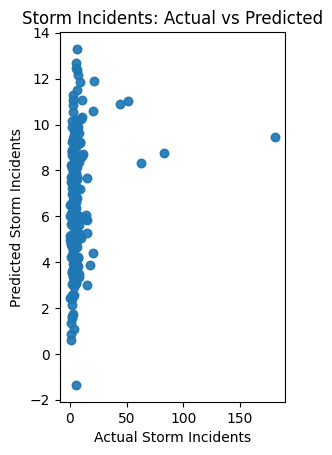

In [37]:
plt.subplot(1, 2, 1)
plt.scatter(combined_data[STORM_INCIDENTS_COLUMN], Y_multi_pred[:, 0], color='tab:blue', alpha=0.7)
plt.xlabel("Actual Storm Incidents")
plt.ylabel("Predicted Storm Incidents")
plt.title("Storm Incidents: Actual vs Predicted")

Text(0.5, 1.0, 'Wires Down Incidents: Actual vs Predicted')

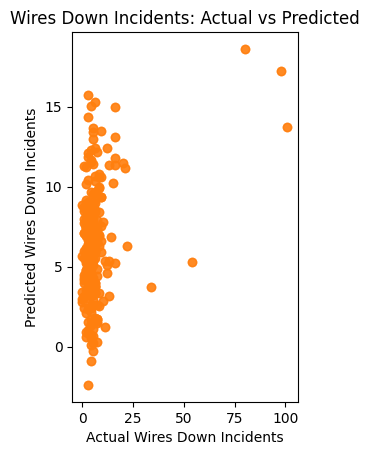

In [38]:
plt.subplot(1, 2, 2)
plt.scatter(combined_data[WIRES_DOWN_COLUMN], Y_multi_pred[:, 1], color='tab:orange', alpha=0.7)
plt.xlabel("Actual Wires Down Incidents")
plt.ylabel("Predicted Wires Down Incidents")
plt.title("Wires Down Incidents: Actual vs Predicted")

In [39]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [40]:
def load_weather_data(filepath, city):
    """
    Load a weather CSV/TXT file, drop any extraneous index column,
    convert the 'Date' column to datetime, and assign a 'City' label.
    """
    try:
        df = pd.read_csv(filepath, encoding='utf-8-sig')
    except Exception as e:
        raise FileNotFoundError(f"Error loading {filepath}: {e}")
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'Date' not in df.columns:
        raise KeyError(f"Expected a 'Date' column in file: {filepath}")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['City'] = city
    return df

In [41]:
# Define file paths for the three weather datasets.
wollongong_fp = os.path.expanduser("DataFiles/combined_Wollongong.csv")
sydney_fp     = os.path.expanduser("DataFiles/combined_attributes.csv")
newcastle_fp  = os.path.expanduser("DataFiles/combined_Newcastle.csv")

In [42]:
# Load each weather dataset.
wollongong_weather = load_weather_data(wollongong_fp, "Wollongong")
sydney_weather     = load_weather_data(sydney_fp, "Sydney")
newcastle_weather  = load_weather_data(newcastle_fp, "Newcastle")

In [43]:
# Combine all weather data.
combined_weather = pd.concat([wollongong_weather, sydney_weather, newcastle_weather], ignore_index=True)
combined_weather.sort_values("Date", inplace=True)
print("Combined Weather Data Preview:")
print(combined_weather.head())

Combined Weather Data Preview:
           Date  Minimum temperature (°C)  Maximum temperature (°C)  \
0    2024-04-01                      17.9                      26.8   
550  2024-04-01                      18.0                      28.6   
825  2024-04-01                      18.0                      28.6   
1100 2024-04-01                      18.9                      24.3   
1375 2024-04-01                      18.9                      24.3   

      Rainfall (mm)  Evaporation (mm)  Sunshine (hours)  \
0               0.0               NaN               NaN   
550             0.0               4.4              10.5   
825             0.0               4.4              10.5   
1100            0.0               NaN               NaN   
1375            0.0               NaN               NaN   

     Direction of maximum wind gust   Speed of maximum wind gust (km/h)  \
0                                 NE                               48.0   
550                               NE 

In [44]:
# Define key weather metrics.
weather_cols = ["9am Temperature (°C)", "9am relative humidity (%)", "9am wind speed (km/h)"]

In [45]:
# Replace non-numeric wind speed texts like "Calm" with 0.
combined_weather["9am wind speed (km/h)"] = combined_weather["9am wind speed (km/h)"].replace(
    r'(?i)^\s*calm\s*$', "0", regex=True
)
for col in weather_cols:
    combined_weather[col] = pd.to_numeric(combined_weather[col], errors='coerce')

In [46]:
# Aggregate weather data by City (averaging across all daily records).
weather_by_city = combined_weather.groupby('City')[weather_cols].mean().reset_index()
print("\nAggregated Weather Data by City:")
print(weather_by_city)


Aggregated Weather Data by City:
         City  9am Temperature (°C)  9am relative humidity (%)  \
0   Newcastle             17.162774                  72.850365   
1      Sydney             16.966182                  71.912727   
2  Wollongong             17.274144                  64.726236   

   9am wind speed (km/h)  
0              18.178182  
1              15.530909  
2              17.822222  


=============================================================================
PART 2: LOAD, CLEAN, AND AGGREGATE LGA INCIDENT DATA (Yearly Breakdown)
=============================================================================

In [47]:
# Load the LGA incidents file.
lga_filepath = os.path.expanduser("DataFiles/LGA_Incidents.csv")
try:
    lga_incidents = pd.read_csv(lga_filepath)
except Exception as e:
    raise FileNotFoundError(f"Error loading {lga_filepath}: {e}")

In [48]:
print("\nLGA Incidents Data Preview (Raw):")
print(lga_incidents.head())


LGA Incidents Data Preview (Raw):
  Local Government Area Fires & explosions  \
0                ALBURY                244   
1  ARMIDALE REGIONAL ol                200   
2               BALLINA                 56   
3             BALRANALD                  8   
4              BATHURST                135   

   Non-fire rescue calls including animal rescues  \
0                                            74.0   
1                                            36.0   
2                                           409.0   
3                                            10.0   
4                                            43.0   

   Hazards material incidents & other hazardous conditions  \
0                                              117.0         
1                                               63.0         
2                                               63.0         
3                                                5.0         
4                                               89.0       

In [49]:
# --- Clean Column Names ---
# Remove extra whitespace and any quotation marks from column headers.
lga_incidents.columns = lga_incidents.columns.str.strip().str.replace('"', '')

In [50]:
# Convert numeric columns (all columns except the first) by removing commas and converting to numeric.
for col in lga_incidents.columns[1:]:
    lga_incidents[col] = lga_incidents[col].astype(str).str.replace(",", "").str.strip()
    lga_incidents[col] = pd.to_numeric(lga_incidents[col], errors='coerce')

In [51]:
# Define a mapping from LGA names to City names.
lga_to_city = {
    'SYDNEY': 'Sydney',
    'INNER WEST': 'Sydney',
    'WAVERLEY': 'Sydney',
    'WILLLOUGHBY': 'Sydney',
    'CAMDEN': 'Sydney',
    'CANTERBURY-BANKSTOWN': 'Sydney',
    'BLACKTOWN': 'Sydney',
    'NEWCASTLE': 'Newcastle',
    'LAKE MACQUARIE': 'Newcastle',
    'WOLLONGONG': 'Wollongong',
    'SHELLHARBOUR': 'Wollongong'
    # Extend the mapping as needed.
}

In [52]:
# Ensure the incidents file contains the "Local Government Area" column.
if "Local Government Area" not in lga_incidents.columns:
    raise KeyError("The incidents file must contain a 'Local Government Area' column.")

In [53]:
# Create a "City" column using the mapping.
lga_incidents["City"] = lga_incidents["Local Government Area"].map(lga_to_city)
lga_incidents = lga_incidents.dropna(subset=["City"])
print("\nLGA Incidents with City Assignment (Preview):")
print(lga_incidents.head())


LGA Incidents with City Assignment (Preview):
   Local Government Area  Fires & explosions  \
9              BLACKTOWN              1032.0   
20                CAMDEN               161.0   
24  CANTERBURY-BANKSTOWN               647.0   
60            INNER WEST               275.0   
68        LAKE MACQUARIE               692.0   

    Non-fire rescue calls including animal rescues  \
9                                            622.0   
20                                           193.0   
24                                           756.0   
60                                           221.0   
68                                           366.0   

    Hazards material incidents & other hazardous conditions  \
9                                               927.0         
20                                              212.0         
24                                              943.0         
60                                              383.0         
68                      

In [54]:
# Define the incident column names you want to analyze.
incident_cols = [
    "Fires & explosions", 
    "Storm, floods and other natural disasters & calls for assistance from other agencies",
    "Total primary incidents"
]

In [55]:
# Aggregate incident data by City by taking the average across records (if multiple years exist).
incidents_by_city = lga_incidents.groupby("City")[incident_cols].mean().reset_index()
print("\nAggregated Incident Data by City (Averages):")
print(incidents_by_city[["City", "Total primary incidents"]])


Aggregated Incident Data by City (Averages):
         City  Total primary incidents
0   Newcastle              3637.000000
1      Sydney              5167.166667
2  Wollongong              2462.000000


=============================================================================
PART 3: VISUALIZATION - GROUPED BAR CHART FOR INCIDENT TYPES BY CITY
=============================================================================

In [56]:
# Reshape the incident data to long format for a grouped bar chart.
incidents_long = pd.melt(incidents_by_city,
                         id_vars=["City"],
                         value_vars=incident_cols,
                         var_name="Incident Type",
                         value_name="Average Count")
print("\nIncidents Data (Long Format):")
print(incidents_long)


Incidents Data (Long Format):
         City                                      Incident Type  \
0   Newcastle                                 Fires & explosions   
1      Sydney                                 Fires & explosions   
2  Wollongong                                 Fires & explosions   
3   Newcastle  Storm, floods and other natural disasters & ca...   
4      Sydney  Storm, floods and other natural disasters & ca...   
5  Wollongong  Storm, floods and other natural disasters & ca...   
6   Newcastle                            Total primary incidents   
7      Sydney                            Total primary incidents   
8  Wollongong                            Total primary incidents   

   Average Count  
0     639.500000  
1     485.666667  
2     493.000000  
3     425.000000  
4     214.666667  
5     239.000000  
6    3637.000000  
7    5167.166667  
8    2462.000000  


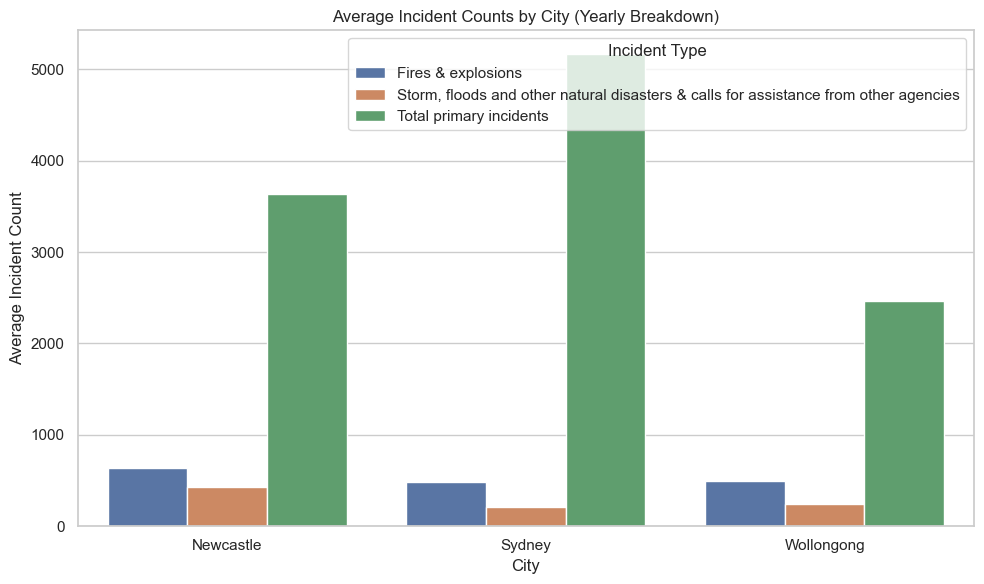

In [57]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="City", y="Average Count", hue="Incident Type", data=incidents_long)
ax.set_title("Average Incident Counts by City (Yearly Breakdown)")
ax.set_xlabel("City")
ax.set_ylabel("Average Incident Count")
plt.legend(title="Incident Type")
plt.tight_layout()
plt.show()

=============================================================================
PART 4: OPTIONAL MERGE & CORRELATION ANALYSIS (City-Level Averages)
=============================================================================

In [58]:
# Merge weather and incident data by City.
merged_city = pd.merge(weather_by_city, incidents_by_city, on="City", how="inner")
print("\nMerged Data by City:")
print(merged_city)


Merged Data by City:
         City  9am Temperature (°C)  9am relative humidity (%)  \
0   Newcastle             17.162774                  72.850365   
1      Sydney             16.966182                  71.912727   
2  Wollongong             17.274144                  64.726236   

   9am wind speed (km/h)  Fires & explosions  \
0              18.178182          639.500000   
1              15.530909          485.666667   
2              17.822222          493.000000   

   Storm, floods and other natural disasters & calls for assistance from other agencies  \
0                                         425.000000                                      
1                                         214.666667                                      
2                                         239.000000                                      

   Total primary incidents  
0              3637.000000  
1              5167.166667  
2              2462.000000  


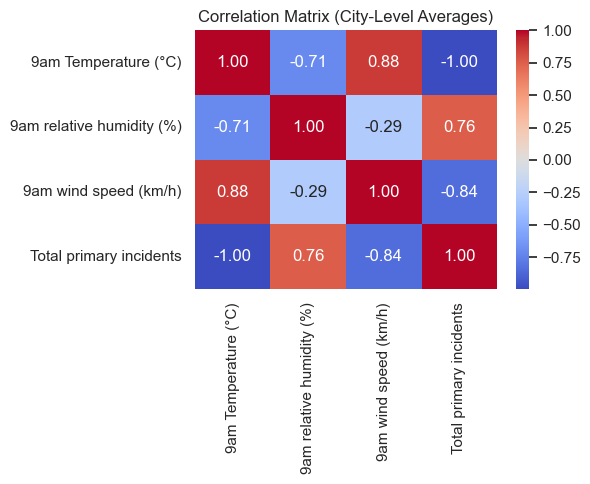

In [59]:
# For correlation analysis, select relevant columns.
cols_for_corr = weather_cols + ["Total primary incidents"]
corr_matrix = merged_city[cols_for_corr].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (City-Level Averages)")
plt.tight_layout()
plt.show()